<h1 align="center">Machine Learning</h1><h2 align="center" style="margin:10px">Assignment 2</h2>

In [1]:
# Student names and numbers:


The assignments below should be solved and documented as a mini-project that will form the basis for the
examination. When solving the exercises it is important that you

  * document all relevant results and analyses that you have obtained/performed during the exercises
  * try to relate your results to the theoretical background of the methods being applied.

Feel free to add cells if you need to. The easiest way to convert to pdf is to save this notebook as .html (File-->Download as-->HTML) and then convert this html file to pdf. You can also export as pdf directly, but here you need to watch your margins as the converter will cut off your code (i.e. make vertical code!).

Last, but not least:
* Looking for an overview of the markdown language? The cheat sheet <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">here</a> might help.
* For most of the Python specific components of the exercises, you should not need constructs beyond those that are already included in the notebooks on the course's web-page (still you should not feel constrained by these, so feel free to be adventurous). You may, however, need to consult the documentation for some of the methods supplied by `sklearn`.

In [2]:
# Import all necessary libraries here
import mglearn
import sys
import nltk
import string 
import numpy as np
import scipy as scipy
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.sparse
%matplotlib inline

from numpy.random import seed
from time import time
from keras.datasets import mnist
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, MaxPooling2D,MaxPooling1D, Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras import optimizers
from gensim.parsing.preprocessing import remove_stopwords

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")
np.set_printoptions(threshold= sys.maxsize)

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\spiri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\spiri\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\spiri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exercise 1: Sentiment analysis

In this exercise we use the IMDB-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [ ]:
reviews = pd.read_csv('IMDB_dataset/reviews.txt', header=None)
labels = pd.read_csv('IMDB_dataset/labels.txt', header=None)
Y = np.array((labels=='positive').astype(np.int_)).ravel()
# print(type(reviews))
# print(reviews[0][0])



**a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing.

**b)** Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. (See an example of how to do this in chapter 7 of "Muller and Guido"). Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

**c)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

**d)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

**e)** Test your sentiment-classifier on the test set.

**f)** Use the classifier to classify a few sentences you write yourselves. 

***Exercise 1 Solution***

Having to work with text data posed the first problem for coming out with a good model solution for the exercise. Text data is often viewed as an interpretation of sentiment, which is unquantifiable by a computer. 

The exercise formulation mentions as requirement the use of a CountVectorizer in the idea of creating a Bag of words, essentially mapping each word of a review to a tuple (key and value) and thus transforming a potential review in an array of tuples. In this case we will attempt creating a new dataset from the one provided where its features will then be represented by the keys contained in the bag of words, and the values will be the actual "data" property in the data set.

To construct the dataset, first the information has to go through a pre-processing step as creating a bag of words could potentially tokenize frequent words that do not necessarily influence or characterize the main "sentiment" of a review. For the exercise in question, the following process was proposed:

**1.** Removal of stop_words: <br>
This step describes the removal of all stop words from the reviews. Example of stop words are 'i', 'am', ''t' etc.

**2.** Punctuation removal: <br>
By creating a bag of words, punctuation is considered a word, or a token itself. Due to the fact that they do not pose a significant value in predicting the affirmativeness of a review, they are removed.

**3.** Lemmatisation of reviews: <br>
Lemmatisation is the process of replacing a word (which presents a specific form depending of its type and the grammar implications of the language) with its prime form that can be found in a dictionary. Like so verbs, nouns or adjectives (didn't, coded, affirmativeness) are transposed (do, code, affirmative). This reduces redundancy in the data set.

<br>
In typical use cases we would have to split our training data from the testing data and perform the pre-processing procedure only on the training data, but due to the fact that we are essentially creating a new data set from the one provided, and the test data has to be reduces to a form which the model ca understand, we will process all reviews at once and then split. 
<br>
Due to the requirement of using a neural network, we will want to calculate the probability of a review to be negative of positive. In this case, the problem resumes to a logistic regression issue.

In [ ]:
# 1. Removal of stop_words
for idx, rev in enumerate(reviews[0]):
    reviews[0][idx] = remove_stopwords(rev, stopwords.words('english') )

In [ ]:
#The result of the removal of stop words can be seen by printing the first few reviews 
print(reviews.head)

<bound method NDFrame.head of                                                        0
0      bromwell high cartoon comedy . ran time progra...
1      story man unnatural feelings pig . starts open...
2      homelessness houselessness george carlin state...
3      airport starts brand new luxury plane loaded v...
4      brilliant acting lesley ann warren . best dram...
...                                                  ...
24995  saw descent last night stockholm film festival...
24996  christmas together actually came time raised j...
24997  films pick pound turn rather good rd century f...
24998  working class romantic drama director martin r...
24999  one dumbest films ever seen . rips nearly ever...

[25000 rows x 1 columns]>


In [ ]:
# 2. Punctuation removal
for idx, rev in enumerate(reviews[0]):
    reviews[0][idx] = rev.translate(str.maketrans('', '', string.punctuation))

In [ ]:
# The result of the removal of punctuation can be seen by printing the first few reviews 
print(reviews.head)

<bound method NDFrame.head of                                                        0
0      bromwell high cartoon comedy  ran time program...
1      story man unnatural feelings pig  starts openi...
2      homelessness houselessness george carlin state...
3      airport starts brand new luxury plane loaded v...
4      brilliant acting lesley ann warren  best drama...
...                                                  ...
24995  saw descent last night stockholm film festival...
24996  christmas together actually came time raised j...
24997  films pick pound turn rather good rd century f...
24998  working class romantic drama director martin r...
24999  one dumbest films ever seen  rips nearly ever ...

[25000 rows x 1 columns]>


In [ ]:
#3. Lemmatisation of reviews 
lmtizer = WordNetLemmatizer()

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
 
 
for idx, rev in enumerate(reviews[0]):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(rev)) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:  
        if tag is None:
            lemmatized_sentence.append(word)
        else:  
            lemmatized_sentence.append(lmtizer.lemmatize(word, tag))
    reviews[0][idx]= " ".join(lemmatized_sentence)
 

The code above is meant to lemmatize each word in each reviews included in the initial data set. The lemmatisation process depends on the type of word that needs to be lemmatised. Using the `nltk.pos_tag` function we can extract the type (or tag) of all words from a review. The nltk tags are quite hard to read, such that they were mapped into a list of more clear options using the defined function in the above code. Using the list of words from a review and their corresponding tag, the review is reconstructed using the results of the lemmatized process.  

In [ ]:
# The result of the lemmatisation process on the first review is the following
print(reviews[0][0])

bromwell high cartoon comedy run time program school life teacher year teach profession lead believe bromwell high satire much closer reality teacher scramble survive financially insightful student see right pathetic teacher pomp pettiness whole situation remind school know student saw episode student repeatedly try burn school immediately recall high classic line inspector sack one teacher student welcome bromwell high expect many adult age think bromwell high far fetch pity


**b)** Having the reviews run through the pre-processing step, the result represents a very concrete, direct message. While some of the nuance of the review is lost, the message becomes more compact and concentrated and less redundant in terms of content. Having this form the reviews can be used to create the bag of words. 

The solution presented in this report makes use of a `TfidfVectorizer` instead of `CountVectorizer`. A `TfidfVectorizer` is an implementation of a `CountVectorizer`, meaning that they output the same ´vocabulary_´, their difference being the value they give when performing transformation of a document (review). A CountVectorizer converts a collection of text documents to a matrix of token counts, meaning that the result of a review transformation will contain the number of times a specific word (in the respective review) appears. TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency, meaning that when token counts are calculated, they are computed and considered across the entire document (data set) and outputs to a frequency, a ratio or weight of a word.

In [ ]:
#4. Tokenizing words
vect = TfidfVectorizer(max_features=10000, stop_words= stopwords.words('english'))
transformed_reviews = vect.fit_transform(reviews[0])

**c)** The result of the transformation is also the dataset we will use to train the neural network on. To read the transformed reviews (a sparse matrix) we will consider the following:

* A row in the matrix corresponds to the output of the transformation of a document for one specific word which is included in the bag of words (one of the most 10000 frequent words)
* The first element of the tuple describes to the review for which the output corresponds. 0 means the first review, 1 the second, 2 the thirds, etc. 
* The second element of the tuple corresponds the index of the word in the bag of words. For example the value 6710 corresponds to the 6710'th most frequent word from the 'vocabulary_' which is ´pity´. If a specific index appears in a tuple, that means that the word it mapped to is included in the review corresponding to the first value in the tuple.
* The value to which the tuple maps corresponds to the frequency the word has in the entire data set. This is also how the words will be represented in the final data set.


In [ ]:
print(transformed_reviews)

  (0, 6710)	0.11950034363725918
  (0, 3337)	0.137302799335336
  (0, 3261)	0.06932324862812123
  (0, 8969)	0.04584721706500551
  (0, 180)	0.08110951562857681
  (0, 136)	0.09614733214310987
  (0, 5515)	0.05490404589168599
  (0, 3151)	0.07323714228205612
  (0, 9748)	0.11804706361208209
  (0, 6291)	0.03284128128186592
  (0, 7692)	0.15057204889412243
  (0, 4618)	0.1347889174185391
  (0, 5255)	0.0673397466196941
  (0, 1578)	0.07749010060053112
  (0, 7250)	0.11747651616388127
  (0, 4450)	0.10683414307557462
  (0, 1171)	0.10737584204656342
  (0, 9243)	0.05621233858721317
  (0, 7395)	0.13442737483054762
  (0, 3003)	0.08405752000690257
  (0, 7772)	0.06771878411874818
  (0, 5022)	0.04942392242584494
  (0, 7370)	0.09638331480183294
  (0, 8155)	0.08908138293337045
  (0, 9789)	0.068673186657198
  :	:
  (24999, 5328)	0.06374111525662078
  (24999, 97)	0.08299198568842231
  (24999, 7774)	0.12833026635764289
  (24999, 8995)	0.12274689379855375
  (24999, 2456)	0.09882551826074257
  (24999, 5295)	0.152914

In [ ]:
#For visualization purposes, the dataset (the tranformed reviews) can be plotted in a data frame.
dataFrame = pd.DataFrame.sparse.from_spmatrix(transformed_reviews)
dataFrame

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
24996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
24997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.198158,0.0,0.0,0.0,0.0,0.0
24998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


**a)** Splitting the training, validation and test is represented by the code below:

In [ ]:
Y = to_categorical(Y,num_classes=2)
X_trainval, X_test, y_trainval, y_test = train_test_split(dataFrame.to_numpy(), Y, random_state=42)
print("Size of training-val set:{}".format(X_trainval.shape[0]))
print("Size of test set:{}".format(X_test.shape[0]))

Size of training-val set:18750
Size of test set:6250


**d)** The code below describes the network configuration and the fitting process of the data in the model.
Observations regarding the neuron network:
*  The validation methodology was applied by mentioning the `validation_split` parameter when fitting the training data. As such, the network performs validations on 0.2 out of bach set on which the network learn at each one epoch. 
*  It was discovered that having a great number of neurons on the input and hidden layer caused the network to look 'to deep' into the data, causing great loss in the validation process, thus overfitting.
* `Relu` was used as activation algorithm as the data was previously stripped of potential noise that could have been treated with `Sigmoid` activation. 
* In general the score of the network comes down to providing a proportional value for the epoch and batch_size. The more we increase the batch_size the more epochs we would like to input. In general it was discovered that 0.2 as the validation split ratio gave the best result, as more would cut to much from the training data, but to little (while increasing the accuracy with even 0.04) caused the training loss to be with even 0.1 smaller then the validation loss, thus indicating that the model is overfitting.
* loss: 0.2291 - accuracy: 0.9113 - val_loss: 0.2819 - val_accuracy: 0.8864 

In [ ]:
model = Sequential()

model.add(Dense(units=64, activation='relu', input_dim=10000)) 
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=2, activation='softmax')) 

sdg = optimizers.Adadelta(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', optimizer=sdg, metrics=['accuracy'])

history = model.fit(X_trainval, y_trainval, validation_split = 0.2, epochs=15, batch_size=100, verbose=1)


Epoch 1/15
150/150 [==============================] - 2s 15ms/step - loss: 0.6901 - accuracy: 0.5292 - val_loss: 0.6859 - val_accuracy: 0.5224
Epoch 2/15
150/150 [==============================] - 2s 12ms/step - loss: 0.6745 - accuracy: 0.6011 - val_loss: 0.6620 - val_accuracy: 0.6947
Epoch 3/15
150/150 [==============================] - 2s 12ms/step - loss: 0.6353 - accuracy: 0.7541 - val_loss: 0.6093 - val_accuracy: 0.7976
Epoch 4/15
150/150 [==============================] - 2s 11ms/step - loss: 0.5613 - accuracy: 0.8292 - val_loss: 0.5229 - val_accuracy: 0.8371
Epoch 5/15
150/150 [==============================] - 2s 12ms/step - loss: 0.4614 - accuracy: 0.8607 - val_loss: 0.4307 - val_accuracy: 0.8531
Epoch 6/15
150/150 [==============================] - 2s 12ms/step - loss: 0.3740 - accuracy: 0.8751 - val_loss: 0.3693 - val_accuracy: 0.8637
Epoch 7/15
150/150 [==============================] - 2s 12ms/step - loss: 0.3172 - accuracy: 0.8876 - val_loss: 0.3343 - val_accuracy: 0.8728

We can visualize the loss and accuracy curves during training using the following: 

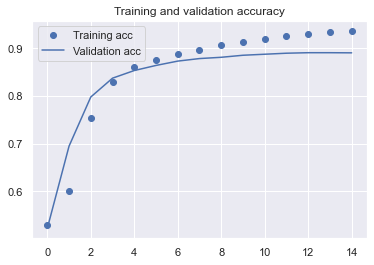

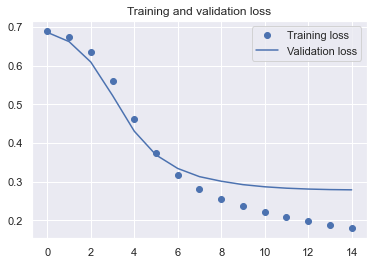

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**e)** To evaluate the network regard the code below:

In [ ]:
print("Accuracy on training data: {}".format(model.evaluate(X_trainval, y_trainval)))
print("Accuracy on testing data: {}".format(model.evaluate(X_test, y_test)))

586/586 [==============================] - 2s 3ms/step - loss: 0.1924 - accuracy: 0.9308
Accuracy on training data: [0.19235852360725403, 0.9308266639709473]
196/196 [==============================] - 1s 3ms/step - loss: 0.2812 - accuracy: 0.8842
Accuracy on testing data: [0.28124672174453735, 0.8841599822044373]


**f)** The reviews were taken from online sources. Before they are predicted, the reviews are taken through a processing function that corresponds to the pre-processing step elaborated above.

In [ ]:
review1 = "There were two interesting look back reviews that came out in 2015 that are worth checking out - just search for <<review terminator sarah connor chronicles>> and check out the retrospectives in The Guardian and on IGN. The IGN retrospective is especially valuable due to the inclusion of video cast interviews that don't show up on YouTube - there are a lot of insights as to how the principle actors viewed their characters and where they hoped the plot and reveals would go. Ultimately the writer Josh Friedman did give us fans what we wanted, just not in the definitive manner the actors hoped for their characters. I think it is better that way - showing us and let us draw our own conclusions, instead of laying it out in black and white. But, yeah, for you Jameron shippers, you were right, the seeds were there all along and the final episode is a real heartbreaker."
review2 = "One of the best stand alone TV Sci-Fi shows ever, joining Firefly on the list of <<why ever did they cancel that >>? Perhaps the best answer is that it is a miracle it was made in the first place, given that cancer survivor Josh Friedman produced a death obsessed, stylish, inventive and often very funny TV show with more depth and sophistication than the dying film franchise. A Hollywood insider needs to write the real back story to this show: how it suited Warner Brothers to have what was, in effect, an extended commercial on TV for the upcoming reboot of the movie franchise, what transpired between Warner and Fox, and why Fox started to pull the plug on the cash. There are episodes in season two that were clearly made with everyone concerned expecting to be fired by the end of the day. The production values dropped as the budget dried up, but the excellent acting, production and cinematography did not. An unfortunate casualty of the writers' strike, the show lost momentum after its truncated first season. Neflix, reboot it, please...."


def transform_review(review):
    review = remove_stopwords(review, stopwords.words('english'))
    review = review.translate(str.maketrans('', '', string.punctuation))
    
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(review)) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:  
        if tag is None:
            lemmatized_sentence.append(word)
        else:  
            lemmatized_sentence.append(lmtizer.lemmatize(word, tag))
    review = " ".join(lemmatized_sentence)
    return review

review1 = transform_review(review1)
review1 = vect.transform([review1])
review1 = pd.DataFrame.sparse.from_spmatrix(review1).to_numpy()

review2 = transform_review(review2)
review2 = vect.transform([review2])
review2 = pd.DataFrame.sparse.from_spmatrix(review2).to_numpy()

prediction1 = model.predict(review1)
prediction2 = model.predict(review2)
print("Review1 has {} chances to be a negative review and {} chances to be positive".format(prediction1[0][0], prediction1[0][1]))
print("Review2 has {} chances to be a negative review and {} chances to be positive".format(prediction2[0][0], prediction2[0][1]))


Review1 has 0.34934672713279724 chances to be a negative review and 0.6506532430648804 chances to be positive
Review2 has 0.08920897543430328 chances to be a negative review and 0.9107910990715027 chances to be positive


# Exercise 2: MNIST

In this exercise, we consider the famous MNIST dataset, which is loaded below. The dataset consists of 70000 handwritten digits 0-9 at a resolution of 28x28 pixels. In the cell below, the dataset is loaded and split into 60000 traning and 10000 testing images. 

In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

The code-snippet below can be used to see the images corresponding to individual digits:

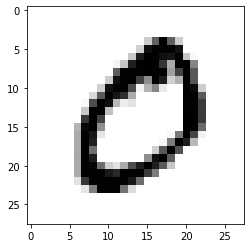

In [11]:
index = 1

plt.imshow(x_train[index],cmap=plt.cm.gray_r)
plt.show()

To make things a little bit simpler (and faster!), we can extract from the data binary subsets, that only contain the data for two selected digits:

### Training a neural network

**a)** Learn different neural network models by varying the network architecture (i.e. number of layers and neurons in each layer) and the type of network (i.e. fully connected vs. convolutional). For each configuration, determine the time it takes to learn the model, and the accuracy on the test data. *Caution*: for some configurations, learning here can take a little while (several minutes).

**b)** Inspect some misclassified cases. Do they correspond to hard to recognize digits (also for the human reader)? (Hint: you can e.g. use the numpy where() function to extract the indices of the test cases that were misclassified: `misclass = np.where(test != predictions)` )

**c)** How do results (time and accuracy) change, depending on whether you consider an 'easy' binary task (e.g., distinguishing '1' and '0'), or a more difficult one (e.g., '4' vs. '5'). 

**d)** Identify one or several good configurations that give a reasonable combination of accuracy and runtime. Use these configurations to perform a full classification of the 10 classes in the original dataset (after split into train/test). Using `sklearn.metrics.confusion_matrix` you can get an overview of all combinations of true and predicted labels (see p. 298-299 in Müller & Guido). What does this tell you about which digits are easy, and which ones are difficult to recognize, and which ones are most easily confused?

*Exercise 2 Solution*

a) 4 layers networks with 784 and 196 neurons in the input layer each and 3 layers with 196 neurons

The first training datapoint now is: 



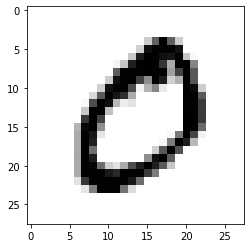

0


In [12]:
# easy task
digit0=0
digit1=1
x_bin_train10_set=x_train[np.logical_or(y_train==digit0,y_train==digit1)]
y_bin_train10_set=y_train[np.logical_or(y_train==digit0,y_train==digit1)]

x_bin_test10_set=x_test[np.logical_or(y_test==digit0,y_test==digit1)]
y_bin_test10_set=y_test[np.logical_or(y_test==digit0,y_test==digit1)]

print("The first training datapoint now is: \n")
plt.imshow(x_bin_train10_set[0],cmap=plt.cm.gray_r)
plt.show()
print(y_bin_train10_set[0])

The first training datapoint now is: 



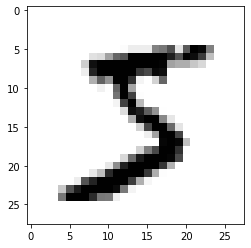

5


In [13]:
# hard task
digit4=4
digit5=5
x_bin_train45_set=x_train[np.logical_or(y_train==digit4,y_train==digit5)]
y_bin_train45_set=y_train[np.logical_or(y_train==digit4,y_train==digit5)]

x_bin_test45_set=x_test[np.logical_or(y_test==digit4,y_test==digit5)]
y_bin_test45_set=y_test[np.logical_or(y_test==digit4,y_test==digit5)]

print("The first training datapoint now is: \n")
plt.imshow(x_bin_train45_set[0],cmap=plt.cm.gray_r)
plt.show()
print(y_bin_train45_set[0])

In [14]:
y_bin_train45_set = np.where(y_bin_train45_set== digit4, 0,y_bin_train45_set)
y_bin_train45_set = np.where(y_bin_train45_set== digit5, 1,y_bin_train45_set)

y_bin_test45_set = np.where(y_bin_test45_set== digit4, 0, y_bin_test45_set)
y_bin_test45_set = np.where(y_bin_test45_set == digit5, 1, y_bin_test45_set)

In [15]:

x_bin_train10_flatten = np.reshape(x_bin_train10_set, [-1, 784])
x_bin_train45_flatten = np.reshape(x_bin_train45_set, [-1, 784])

x_bin_train10_flatten = x_bin_train10_flatten.astype('float32') /255
x_bin_train45_flatten = x_bin_train45_flatten.astype('float32') /255

x_bin_train10 = x_bin_train10_set.astype('float32') /255
x_bin_train45 = x_bin_train45_set.astype('float32') /255

x_bin_test10_flatten = np.reshape(x_bin_test10_set, [-1, 784])
x_bin_test45_flatten = np.reshape(x_bin_test45_set, [-1, 784])

x_bin_test10_flatten = x_bin_test10_flatten.astype('float32') /255
x_bin_test45_flatten = x_bin_test45_flatten.astype('float32') /255

x_bin_test10 = x_bin_test10_set.astype('float32') /255
x_bin_test45 = x_bin_test45_set.astype('float32') /255

y_bin_train10 = to_categorical(y_bin_train10_set)
y_bin_train45 = to_categorical(y_bin_train45_set)

y_bin_test10 = to_categorical(y_bin_test10_set)
y_bin_test45 = to_categorical(y_bin_test45_set)


In [16]:
def showStats(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

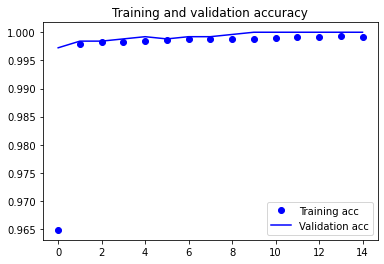

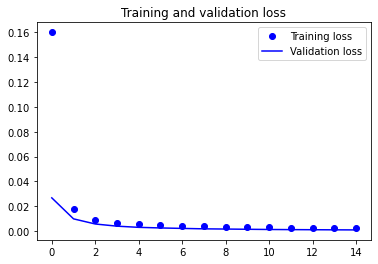

In [17]:
# 3 layers fully connected networks
connected1 = Sequential()

connected1.add(Dense(units=196, activation='relu', input_dim=784)) 
# connected1.add(Dense(units=196, activation='relu'))
connected1.add(Dense(units=32, activation='relu'))
connected1.add(Dense(units=2, activation='softmax')) 

sdg = optimizers.Adadelta(learning_rate=0.1)
connected1 .compile(loss='categorical_crossentropy', optimizer=sdg, metrics=['accuracy'])

t1 = time()
history1 = connected1.fit(x_bin_train10_flatten, y_bin_train10, validation_split = 0.2, epochs=15, batch_size=100, verbose=0)
t1 = time() - t1

showStats(history1)


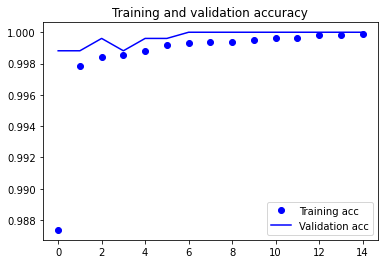

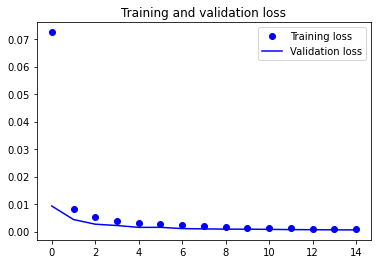

In [18]:
#4 layer fully connected

connected2 = Sequential()

connected2.add(Dense(units=784, activation='relu', input_dim=784)) 
connected2.add(Dense(units=196, activation='relu'))
connected2.add(Dense(units=32, activation='relu'))
connected2.add(Dense(units=2, activation='softmax')) 

sdg = optimizers.Adadelta(learning_rate=0.1)
connected2.compile(loss='categorical_crossentropy', optimizer=sdg, metrics=['accuracy'])

t2 = time()
history2 = connected2.fit(x_bin_train10_flatten, y_bin_train10, validation_split = 0.2, epochs=15, batch_size=100, verbose=0)
t2 = time() - t2

showStats(history2)


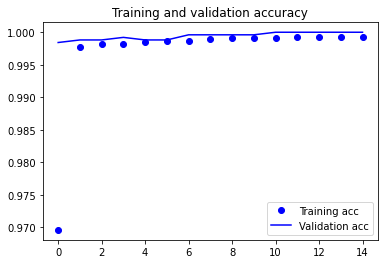

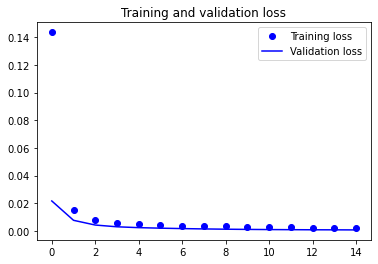

In [19]:
connected3 = Sequential()

connected3.add(Dense(units=196, activation='relu', input_dim=784)) 
connected3.add(Dense(units=49, activation='relu')) 
connected3.add(Dense(units=32, activation='relu'))
connected3.add(Dense(units=2, activation='softmax')) 

sdg = optimizers.Adadelta(learning_rate=0.1)
connected3.compile(loss='categorical_crossentropy', optimizer=sdg, metrics=['accuracy'])

t3 = time()
history3 = connected3.fit(x_bin_train10_flatten, y_bin_train10, validation_split = 0.2, epochs=15, batch_size=100, verbose=0)
t3 = time() -t3
showStats(history3)

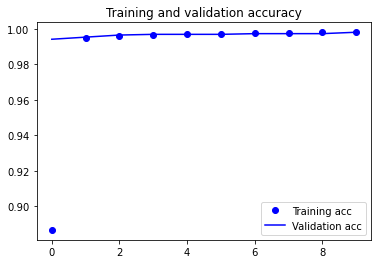

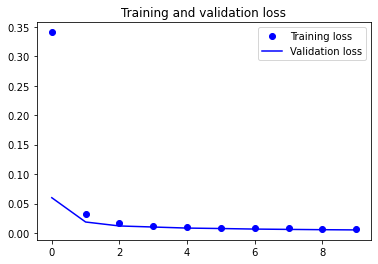

In [20]:
#3 layer convnet
seed(0)
tf.random.set_seed(0)
conv1 = Sequential()

conv1.add(Input(shape= x_bin_test10[0].shape))
conv1.add(Conv1D(32, kernel_size=3, activation='relu'))
conv1.add(MaxPooling1D(pool_size=2))

conv1.add(Conv1D(16, kernel_size=3, activation='relu'))
conv1.add(MaxPooling1D(pool_size=2, padding='same'))

conv1.add(Flatten()) 
conv1.add(Dense(units=2, activation='softmax'))

adadelta = optimizers.Adadelta(learning_rate=0.1)
conv1.compile(loss='categorical_crossentropy', optimizer=adadelta, metrics=['accuracy'])

t_conv1 = time()
history_conv1 = conv1.fit(x_bin_train10, y_bin_train10, validation_split=0.2, epochs=10, batch_size=50, verbose=0)
t_conv1 = time()- t_conv1
showStats(history_conv1)

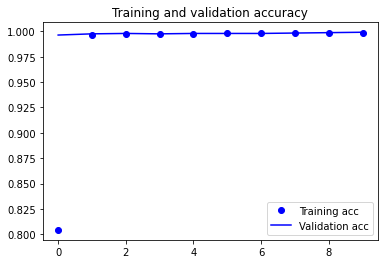

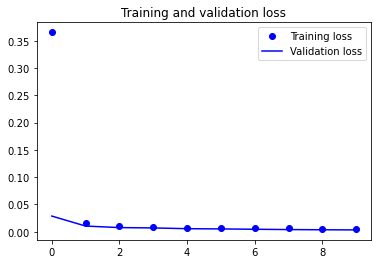

In [21]:
seed(0)
tf.random.set_seed(0)
conv2 = Sequential()

conv2.add(Input(shape= x_bin_test10[0].shape))
conv2.add(Conv1D(32, kernel_size=3, activation='relu'))
conv2.add(MaxPooling1D(pool_size=2))

conv2.add(Conv1D(16, kernel_size=5, activation='relu'))
conv2.add(MaxPooling1D(pool_size=2, padding='same'))

conv2.add(Conv1D(8, kernel_size=3, activation='relu'))
conv2.add(MaxPooling1D(pool_size=2, padding='same'))

conv2.add(Flatten()) 
conv2.add(Dense(units=2, activation='softmax'))

adadelta = optimizers.Adadelta(learning_rate=0.1)
conv2.compile(loss='categorical_crossentropy', optimizer=adadelta, metrics=['accuracy'])

t_conv2 = time()
history_conv2 = conv2.fit(x_bin_train10, y_bin_train10, validation_split=0.2, epochs=10, batch_size=50, verbose=0)
t_conv2 = time() -t_conv2
showStats(history_conv2)


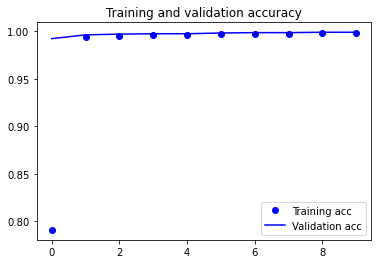

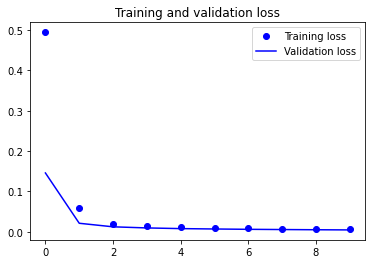

In [22]:
seed(0)
tf.random.set_seed(0)
conv3 = Sequential()

conv3.add(Input(shape= x_bin_test10[0].shape))
conv3.add(Conv1D(16, kernel_size=3, activation='relu'))
conv3.add(MaxPooling1D(pool_size=2))

conv3.add(Conv1D(8, kernel_size=5, activation='relu'))
conv3.add(MaxPooling1D(pool_size=2, padding='same'))

conv3.add(Conv1D(4, kernel_size=3, activation='relu'))
conv3.add(MaxPooling1D(pool_size=2, padding='same'))

conv3.add(Flatten()) 
conv3.add(Dense(units=2, activation='softmax'))

adadelta = optimizers.Adadelta(learning_rate=0.1)
conv3.compile(loss='categorical_crossentropy', optimizer=adadelta, metrics=['accuracy'])

t_conv3 = time()
history_conv3 = conv3.fit(x_bin_train10, y_bin_train10, validation_split=0.2, epochs=10, batch_size=50, verbose=0)
t_conv3 = time() - t_conv3
showStats(history_conv3)



In [23]:
# hard task 6 and 9

connected1_45 = Sequential()

connected1_45.add(Dense(units=196, activation='relu', input_dim=784)) 
connected1_45.add(Dense(units=32, activation='relu'))
connected1_45.add(Dense(units=2, activation='softmax')) 

sdg = optimizers.Adadelta(learning_rate=0.1)
connected1_45 .compile(loss='categorical_crossentropy', optimizer=sdg, metrics=['accuracy'])

t1_45 = time()
history1_45 = connected1_45.fit(x_bin_train45_flatten, y_bin_train45, validation_split = 0.2, epochs=15, batch_size=100, verbose=0)
t1_45 = time() - t1_45

#
connected2_45 = Sequential()

connected2_45.add(Dense(units=784, activation='relu', input_dim=784)) 
connected2_45.add(Dense(units=196, activation='relu'))
connected2_45.add(Dense(units=32, activation='relu'))
connected2_45.add(Dense(units=2, activation='softmax')) 

sdg = optimizers.Adadelta(learning_rate=0.1)
connected2_45.compile(loss='categorical_crossentropy', optimizer=sdg, metrics=['accuracy'])

t2_45 = time()
history2_45 = connected2_45.fit(x_bin_train45_flatten, y_bin_train45, validation_split = 0.2, epochs=15, batch_size=100, verbose=0)
t2_45 = time() - t2_45


#
connected3_45 = Sequential()

connected3_45.add(Dense(units=196, activation='relu', input_dim=784)) 
connected3_45.add(Dense(units=49, activation='relu')) 
connected3_45.add(Dense(units=32, activation='relu'))
connected3_45.add(Dense(units=2, activation='softmax')) 

sdg = optimizers.Adadelta(learning_rate=0.1)
connected3_45.compile(loss='categorical_crossentropy', optimizer=sdg, metrics=['accuracy'])

t3_45 = time()
history3_45 = connected3_45.fit(x_bin_train45_flatten, y_bin_train45, validation_split = 0.2, epochs=15, batch_size=100, verbose=0)
t3_45 = time() -t3_45



#

conv1_45 = Sequential()

conv1_45.add(Input(shape= x_bin_test10[0].shape))
conv1_45.add(Conv1D(32, kernel_size=3, activation='relu'))
conv1_45.add(MaxPooling1D(pool_size=2))

conv1_45.add(Conv1D(16, kernel_size=3, activation='relu'))
conv1_45.add(MaxPooling1D(pool_size=2, padding='same'))

conv1_45.add(Flatten()) 
conv1_45.add(Dense(units=2, activation='softmax'))

adadelta = optimizers.Adadelta(learning_rate=0.1)
conv1_45.compile(loss='categorical_crossentropy', optimizer=adadelta, metrics=['accuracy'])

t_conv1_45 = time()
history_conv1_45 = conv1_45.fit(x_bin_train45, y_bin_train45, validation_split=0.2, epochs=10, batch_size=50, verbose=0)
t_conv1_45 = time()- t_conv1_45

#
conv2_45 = Sequential()

conv2_45.add(Input(shape= x_bin_test10[0].shape))
conv2_45.add(Conv1D(32, kernel_size=3, activation='relu'))
conv2_45.add(MaxPooling1D(pool_size=2))

conv2_45.add(Conv1D(16, kernel_size=5, activation='relu'))
conv2_45.add(MaxPooling1D(pool_size=2, padding='same'))

conv2_45.add(Conv1D(8, kernel_size=3, activation='relu'))
conv2_45.add(MaxPooling1D(pool_size=2, padding='same'))

conv2_45.add(Flatten()) 
conv2_45.add(Dense(units=2, activation='softmax'))

adadelta = optimizers.Adadelta(learning_rate=0.1)
conv2_45.compile(loss='categorical_crossentropy', optimizer=adadelta, metrics=['accuracy'])

t_conv2_45 = time()
history_conv2_45 = conv2_45.fit(x_bin_train45, y_bin_train45, validation_split=0.2, epochs=10, batch_size=50, verbose=0)
t_conv2_45 = time() -t_conv2_45

#

conv3_45 = Sequential()

conv3_45.add(Input(shape= x_bin_test10[0].shape))
conv3_45.add(Conv1D(16, kernel_size=3, activation='relu'))
conv3_45.add(MaxPooling1D(pool_size=2))

conv3_45.add(Conv1D(8, kernel_size=5, activation='relu'))
conv3_45.add(MaxPooling1D(pool_size=2, padding='same'))

conv3_45.add(Conv1D(4, kernel_size=3, activation='relu'))
conv3_45.add(MaxPooling1D(pool_size=2, padding='same'))

conv3_45.add(Flatten()) 
conv3_45.add(Dense(units=2, activation='softmax'))

adadelta = optimizers.Adadelta(learning_rate=0.1)
conv3_45.compile(loss='categorical_crossentropy', optimizer=adadelta, metrics=['accuracy'])

t_conv3_45 = time()
history_conv3_45 = conv3_45.fit(x_bin_train45, y_bin_train45, validation_split=0.2, epochs=10, batch_size=50, verbose=0)
t_conv3_45 = time() - t_conv3_45

In [24]:
#Now we evaluate all networks performance

net1TrainScore = connected1.evaluate(x_bin_train10_flatten, y_bin_train10)
net1TestScore = connected1.evaluate(x_bin_test10_flatten, y_bin_test10)

net2TrainScore = connected2.evaluate(x_bin_train10_flatten, y_bin_train10)
net2TestScore = connected2.evaluate(x_bin_test10_flatten, y_bin_test10)

net3TrainScore = connected3.evaluate(x_bin_train10_flatten, y_bin_train10)
net3TestScore = connected3.evaluate(x_bin_test10_flatten, y_bin_test10)

net_conv1TrainScore = conv1.evaluate(x_bin_train10, y_bin_train10)
net_conv1TestScore = conv1.evaluate(x_bin_test10, y_bin_test10)

net_conv2TrainScore = conv2.evaluate(x_bin_train10, y_bin_train10)
net_conv2TestScore = conv2.evaluate(x_bin_test10, y_bin_test10)

net_conv3TrainScore = conv3.evaluate(x_bin_train10, y_bin_train10)
net_conv3TestScore = conv3.evaluate(x_bin_test10, y_bin_test10)



net1TrainScore_45 = connected1_45.evaluate(x_bin_train45_flatten, y_bin_train45)
net1TestScore_45 = connected1_45.evaluate(x_bin_test45_flatten, y_bin_test45)

net2TrainScore_45 = connected2_45.evaluate(x_bin_train45_flatten, y_bin_train45)
net2TestScore_45 = connected2_45.evaluate(x_bin_test45_flatten, y_bin_test45)

net3TrainScore_45 = connected3_45.evaluate(x_bin_train45_flatten, y_bin_train45)
net3TestScore_45 = connected3_45.evaluate(x_bin_test45_flatten, y_bin_test45)

net_conv1TrainScore_45 = conv1_45.evaluate(x_bin_train45, y_bin_train45)
net_conv1TestScore_45 = conv1_45.evaluate(x_bin_test45, y_bin_test45)

net_conv2TrainScore_45 = conv2_45.evaluate(x_bin_train45, y_bin_train45)
net_conv2TestScore_45 = conv2_45.evaluate(x_bin_test45, y_bin_test45)

net_conv3TrainScore_45 = conv3_45.evaluate(x_bin_train45, y_bin_train45)
net_conv3TestScore_45 = conv3_45.evaluate(x_bin_test45, y_bin_test45)


59/59 [==============================] - 0s 1ms/step - loss: 0.0342 - accuracy: 0.9909


In [25]:
data_10 = {'Train accuracy':[net1TrainScore[1], net2TrainScore[1],  net3TrainScore[1], net_conv1TrainScore[1], net_conv2TrainScore[1], net_conv3TrainScore[1] ], 
        'Train loss':[net1TrainScore[0], net2TrainScore[0],  net3TrainScore[0], net_conv1TrainScore[0], net_conv2TrainScore[0], net_conv3TrainScore[0] ], 
        'Validation accuracy mean': [np.mean(history1.history['val_accuracy']),np.mean(history2.history['val_accuracy']), np.mean(history3.history['val_accuracy']), np.mean(history_conv1.history['val_accuracy']), np.mean(history_conv2.history['val_accuracy']), np.mean(history_conv3.history['val_accuracy'])],
        'Validation loss mean': [np.mean(history1.history['val_loss']), np.mean(history2.history['val_loss']), np.mean(history3.history['val_loss']), np.mean(history_conv1.history['val_loss']), np.mean(history_conv2.history['val_loss']), np.mean(history_conv3.history['val_loss'])],
        'Test accuracy': [net1TestScore[1], net2TestScore[1], net3TestScore[1], net_conv1TestScore[1], net_conv1TestScore[1], net_conv1TestScore[1]], 
        'Test loss': [net1TestScore[0], net2TestScore[0], net3TestScore[0], net_conv1TestScore[0], net_conv1TestScore[0], net_conv1TestScore[0]], 
        'Learning Time':[t1, t2, t3, t_conv1, t_conv2, t_conv3]}  

indexes_10 = ['3l fully con', '4l fully con (784)', '4l fully con (196)', '3l conv', '4l conv (32)', '4l conv (16)']

dataframe_10 = pd.DataFrame(data= data_10, index= indexes_10, )
print("Results for networks trained on 1 and 0:")
dataframe_10

Results for networks trained on 1 and 0:


,Train accuracy,Train loss,Validation accuracy mean,Validation loss mean,Test accuracy,Test loss,Learning Time
3l fully con,0.999368,0.002038,0.999263,0.004403,0.999527,0.001960,2.636818
4l fully con (784),1.000000,0.000633,0.999684,0.001917,0.999527,0.001505,7.642694
4l fully con (196),0.999447,0.001685,0.999421,0.003410,0.999527,0.001831,2.662623
3l conv,0.997947,0.006400,0.996605,0.014036,0.998582,0.003180,4.095747
4l conv (32),0.998579,0.004536,0.998026,0.007933,0.998582,0.003180,4.600647
4l conv (16),0.998184,0.006110,0.997197,0.022507,0.998582,0.003180,4.170974


In [26]:
data_45 = {'Train accuracy':[net1TrainScore_45[1], net2TrainScore_45[1],  net3TrainScore_45[1], net_conv1TrainScore_45[1], net_conv2TrainScore_45[1], net_conv3TrainScore_45[1] ], 
        'Train loss':[net1TrainScore_45[0], net2TrainScore_45[0],  net3TrainScore_45[0], net_conv1TrainScore_45[0], net_conv2TrainScore_45[0], net_conv3TrainScore_45[0] ], 
        'Validation accuracy mean': [np.mean(history1_45.history['val_accuracy']),np.mean(history2_45.history['val_accuracy']), np.mean(history3_45.history['val_accuracy']), np.mean(history_conv1_45.history['val_accuracy']), np.mean(history_conv2_45.history['val_accuracy']), np.mean(history_conv3_45.history['val_accuracy'])],
        'Validation loss mean': [np.mean(history1_45.history['val_loss']), np.mean(history2_45.history['val_loss']), np.mean(history3_45.history['val_loss']), np.mean(history_conv1_45.history['val_loss']), np.mean(history_conv2_45.history['val_loss']), np.mean(history_conv3_45.history['val_loss'])],
        'Test accuracy': [net1TestScore_45[1], net2TestScore_45[1], net3TestScore_45[1], net_conv1TestScore_45[1], net_conv1TestScore_45[1], net_conv1TestScore_45[1]], 
        'Test loss': [net1TestScore_45[0], net2TestScore_45[0], net3TestScore_45[0], net_conv1TestScore_45[0], net_conv1TestScore_45[0], net_conv1TestScore_45[0]], 
        'Learning Time':[t1_45, t2_45, t3_45, t_conv1_45, t_conv2_45, t_conv3_45]}  

indexes_45 = ['3l fully con', '4l fully con (784)', '4l fully con (196)', '3l conv', '4l conv (32)', '4l conv (16)']

dataframe_45 = pd.DataFrame(data= data_45, index= indexes_45, )
print("Results for networks trained on 6 and 9:")
dataframe_45

Results for networks trained on 6 and 9:


,Train accuracy,Train loss,Validation accuracy mean,Validation loss mean,Test accuracy,Test loss,Learning Time
3l fully con,0.996981,0.011212,0.991212,0.031919,0.997866,0.009391,2.310130
4l fully con (784),0.998579,0.006430,0.992395,0.026595,0.998399,0.005006,7.045424
4l fully con (196),0.997603,0.009203,0.990413,0.029540,0.997332,0.009195,2.523118
3l conv,0.994762,0.019658,0.987528,0.061974,0.996265,0.012345,3.646966
4l conv (32),0.995472,0.017399,0.987838,0.043874,0.996265,0.012345,4.128524
4l conv (16),0.986504,0.040654,0.959121,0.135645,0.996265,0.012345,5.025021


### Cheating

We next investigate the capability of the neural networks to find a good model, knowing that a very accurate model exists. For this, we add some 'cheat info' to our data: we replace the first pixel value in the data matrix by a digit that simply contains a 0/1 encoding of the actual class label: 

In [ ]:
#adding cheating information to the training data:
cheatcol_train=np.array(y_bin_train) #making a copy of the original target array
cheatcol_train[cheatcol_train==digit0]=0  #re-coding the two classes as 0s and 1s
cheatcol_train[cheatcol_train==digit1]=
x_bin_cheat_train = np.copy(x_bin_train)
x_bin_cheat_train[:,0,0] = cheatcol_train.reshape(len(cheatcol_train))

#adding cheating information to the testing data:
cheatcol_test=np.array(y_bin_test) #making a copy of the original target array
cheatcol_test[cheatcol_test==digit0]=0  #re-coding the two classes as 0s and 1s
cheatcol_test[cheatcol_test==digit1]=1
x_bin_cheat_test = np.copy(x_bin_test)
x_bin_cheat_test[:,0,0] = cheatcol_test.reshape(len(cheatcol_test))

NameError: name 'y_bin_train' is not defined

The neural networks should, in principle, be able to construct a 100% accurate classifier for this data: we only have to 'learn' that only the first pixel in the data matters. 

**e)** Describe, briefly, how the weights of a (fully connected) network (with arbitrary number of layers) would have to be set, so that the resulting model is 100% accurate on this cheating data. This part of the exercise does not involve any Python code. Just give your answer in a short text.

**f)** Investigate how the accuracy improves in practice on this new dataset. Do you achieve 100% accuracy on the test set? If not, try to change the encoding in the cheat column: instead of representing digit1 with a 1, use a larger number, e.g. 250. Does that help? Why?

# Exercise 3 - Data preparation, exploration and feature engineering

In this exercise, you are going to investigate student dropout based on the dataset "churn2000.cvs". This is a real dataset, and there is no single "correct" way to use it (however, there are several wrong ones!). Your exercise is to explore one or more possible usecases, and document the one(s) you find the most fruitful/interesting.  Your work should probably include the steps below:

- An investigation of the data, using e.g. FACETs, Pandas, and/or whatever other tools you prefer. Can you find any interesting correlations? Are there problematic features or rows in the dataset?
- Handle missing data and possible outliers (in each case, consider what you want to do: Remove row? Remove column? Insert custom value?).
- Normalize/bin/create dummy variables where relevant. 
- Determine what you would like to predict, i.e. choose your target variable. Try formulating a specific usecase for your experiment (e.g. "Given a students perfomance in high school and first semester, what is the probability that he/she churns in the 2. semester?")
- Train a neural network and at least one other algorithm on the data. Find a good set of hyperparameters for each model. Do you think a neural network is suitable for this kind of problem? Why/why not?
- What features seem to be important for predicting whether a student is likely to drop out?

Warning: Make sure you carefully consider what information is available at the time where a prediction is to be made - for example, it doesn't make any sense to try to predict if a student churns in semester 1, if you include a feature which tells that this student churned in semester 2!  So depending on your specific usecase, you should probably remove some columns and/or rows before you train your model.

# Exercise 4: Reinforcement Learning

You can carry out this part of the project either in a jupyter notebook or in a google colab notebook - the latter option allows you to easily use the GPU, rather than the CPU, for training, which is MUCH faster! See these videos for how to get started with google colab notebooks: https://www.youtube.com/watch?v=inN8seMm7UI (for getting started) and https://www.youtube.com/watch?v=PitcORQSjNM (for using the GPU). At the end, you can simply merge the generated pdfs when you submit your project. 


In this final exercise, we are going to explore the concept of reinforcement learning by training a neural network to play a game of your own choice.

We will use the environments provided in OpenAI Gym https://gym.openai.com/ and also documented here: https://github.com/openai/gym/wiki

Instead of implementing Q-learning yourselves, you are welcome to simply run a pre-coded example.
You can look here for inspiration: https://github.com/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb 

In the exercise, toy around with the parameters, and see if you can optimize learning. You should also explain the basics of what is going on. Include some pictures of the animation, and report your score.

a) Give a short description of the rules and incentives in the game.

b) Run the code (either directly in the notebook or on Colab), and show how the training progresses, for example by taking screenshots and including them as pictures in the notebook.

c) Give a short description of what is going on in the code. This should include a description of the neural network, the inputs and outputs to the neural network, and the process of Q-learning.

d) Report the highest score your network was able to obtain. 